# Baseline model testing

In [1]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import plot.single as plt_single
import imp
import importlib
import numpy as np
import pandas as pd
import pickle
imp.reload(mod_code)
import matplotlib.pyplot as plt
import model.base_inputs as base_inputs
import experiments.POM as POM
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [31]:
# POM
f = '../../outputs/2020_2_5_10/POM/200000_20reps/input_params_0.pkl'
f = '../../outputs/2020_2_12_9/POM/10000_10reps/input_params_0.pkl'
inputs_pom = pickle.load(open(f, 'rb'))

inputs = base_inputs.compile()
print(inputs['livestock']['consumption'])
for k, v in inputs_pom.items():
    for k2, v2 in v.items():
        inputs[k][k2] = v2
print(inputs['livestock']['consumption'])

2280
566.0


In [32]:
# imp.reload(mod_code)
# imp.reload(base_inputs)
# inputs = base_inputs.compile()

In [33]:
inputs['model']['T'] = 50
inputs['model']['n_agents'] = 300
inputs['model']['seed'] = 0

In [19]:
# inputs['rangeland']['range_farm_ratio'] = 0.5
# inputs['rangeland']['gr2'] = 0.1
# inputs['agents']['savings_acct'] = True
# inputs['rangeland']['gr2'] = 0.1
# inputs['rangeland']['R_mortality'] = 0.1
# inputs['land']['fallow_N_add'] *= 5
# inputs['agents']['n_yr_smooth'] = 3
# inputs['climate']['rain_mu'] = 0.5
# inputs['agents']['savings_acct'] = False
# inputs['agents']['salary_jobs_availability'] *= 0.5
# inputs['agents']['savings_init_mean'] = 0
# inputs['agents']['livestock_init'] = 5
# inputs['agents']['jobs_availability'] *= 20
# inputs['agents']['living_cost_min_frac'] = 0.9
# inputs['agents']['living_cost_pp'] *= 5
# inputs['agents']['read_from_file'] = False
# inputs['agents']['hh_size_init'] = 12
inputs['agents']['savings_acct'] = False
# inputs['agents']['land_area_init'] = [1]
# inputs['land']['random_effect_sd'] = 0
# inputs['livestock']['consumption'] = 2457/2
# inputs['agents']['ls_labor_rqmt'] = 0.318*2
# inputs['agents']['salary_jobs_availability'] = 0.487/8
# inputs['agents']['wage_jobs_availability'] = 0.14*4

In [34]:
inputs['agents']['wage_jobs_availability']

0.09109297540342631

In [35]:
inputs['agents']['file_name'] = '../../inputs/lsla_for_abm.csv'
importlib.reload(mod_code)
m = mod_code.Model(inputs)
for t in range(m.T):
    m.step()
    
mod=m  
n_yrs = 10
p_cope = np.mean(mod.agents.cons_red_rqd[-n_yrs:])
one = True if ((p_cope>=0.3) & (p_cope<=0.45)) else False
#### NOTE: REMOVING THIS ONE BECAUSE IT CONFLICTS WITH THE WAGE AND SALARY REQUIREMENTS AND LIVESTOCK
#### (IE HAVING 30-45% OF PEOPLE NEEDING TO COPE BUT >80% WITH LIVESTOCK AND <15% WITH WAGE IS ROUGH)
print('one')
print(one)

## 2. land degradation exists
# not consistently someone at maximum value
# (this is calculated over TIME, not a single AGENT that's at max) 
maxs = np.max(mod.land.organic[-n_yrs:], axis=1)
two = False if max(maxs) == mod.land.max_organic_N else True
print('two')
print(two)

## 3. rangeland is not fully degrated
## A: P(regional destocking required) \in [0.1,0.5]
prob = np.mean(mod.rangeland.destocking_rqd)
threeA = True if ((prob >= 0) and (prob <= 0.5)) else False
## B: min(reserve biomass) > 0.2*R_max
threeB = True if min(mod.rangeland.R >= 0.2 * mod.rangeland.R_max) else False
## C: there are livestock on the rangeland in the last n_yrs
# threeC = True if (min(mod.rangeland.livestock_supported[-n_yrs:]) > 0) else False
three = bool(threeA * threeB)
print('three')
print(three)

## 4. livestock: 
# >80% of HHs have livestock on average
fourA = np.mean(mod.agents.livestock[-n_yrs:]>0) >= 0.8
# 90th%ile agent has less than 10 livestock on average
fourB = np.percentile(np.mean(mod.agents.livestock, axis=0), 90) < 10 # take mean over time for each agent
# median agent has less than 5 on average
fourC = np.percentile(np.mean(mod.agents.livestock, axis=0), 50) < 5
# maximum ever is less than 50
fourD = np.max(mod.agents.livestock)<50
four = bool(fourA*fourB*fourC*fourD)
# four = bool(fourA*fourB*fourD)
print('four')
print(fourA)
print(fourB)
print(fourC)
print(fourD)

## 5. non-farm income
# upper and lower limits on wage and salary income
p_wage = np.mean(mod.agents.wage_labor[-n_yrs:] > 0)
p_sal = np.mean(mod.agents.salary_labor[-n_yrs:] > 0)
# print(p_sal)
fiveA = ((p_wage>0.05) & (p_wage<0.15))
fiveB = ((p_sal>0.05) & (p_sal<0.15))
# fiveA = ((p_wage>0.1) & (p_wage<0.15))
# fiveB = ((p_sal>0.05) & (p_sal<0.1))
# code.interact(local=dict(globals(), **locals()))
five = bool(fiveA*fiveB)
print(p_wage)
print(p_sal)

one
False
two
True
three
False
four
False
False
False
False
0.079
0.13333333333333333


## path dependence plots
plot a single agent type (2-3 agents) and see how their outcomes evolve over time
to investigate path dependence and stochasticity in the model

In [36]:
# import plotly.graph_objects as go
# fig = go.Figure()
# for ix in ag_ix:
#     fig.add_trace(go.Scatter(x=np.arange(m.T), y=ag.livestock[:,ix], name=str(ix)))
# fig.show()

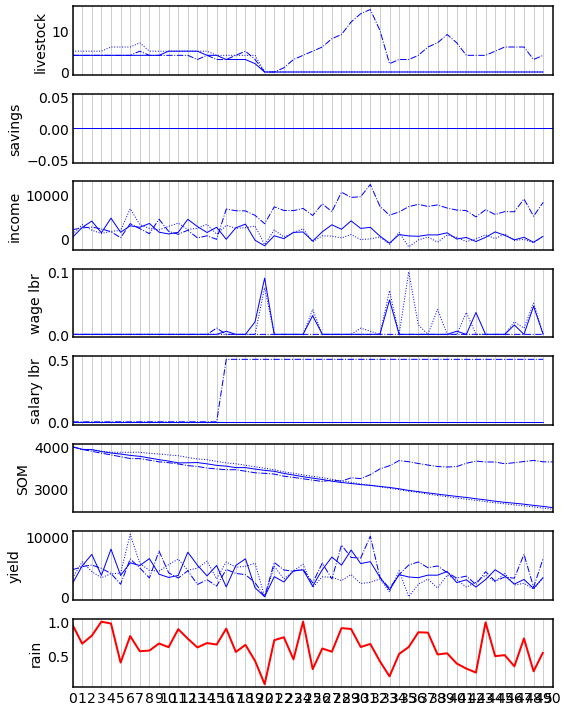

In [37]:
# livestock, wealth, income, % non-farm income (salary + wage), yield, som, rain
ha = 0.5
size = 6
num_plot = 3

fig, axs = plt.subplots(8,1,figsize=(8,10), sharex=True)
ax_flat = axs.flatten()
lss = [':','-','-.']
ag = m.agents
objs = [ag.livestock, ag.savings, ag.income, ag.wage_labor, ag.salary_labor, m.land.organic, m.land.yields]
names = ['livestock','savings','income','wage lbr','salary lbr','SOM','yield']
ag_ix = np.arange(ag.N)[((ag.land_area==ha) * (ag.hh_size==size))][0:num_plot]

for o, obj in enumerate(objs):
    for i, ix in enumerate(ag_ix):
        ax_flat[o].plot(obj[:,ix], ls=lss[i], lw=1, color='b')
    # format
    ax_flat[o].set_ylabel(names[o])
ax_flat[-1].plot(m.climate.rain, color='r')
ax_flat[-1].set_ylabel('rain')
ax_flat[-1].set_xticks(np.arange(m.T+1))
ax_flat[-1].set_xlim([0, m.T])

for ax in ax_flat:
    ax.grid(which='major', axis='y')#, linestyle='--')

## general plots

In [38]:
# fig, ax = plt.subplots()
# ax.plot(m.agents.crop_production[:,-1]/1000)
# ax.plot(m.agents.ls_start[:,-1], color='k')

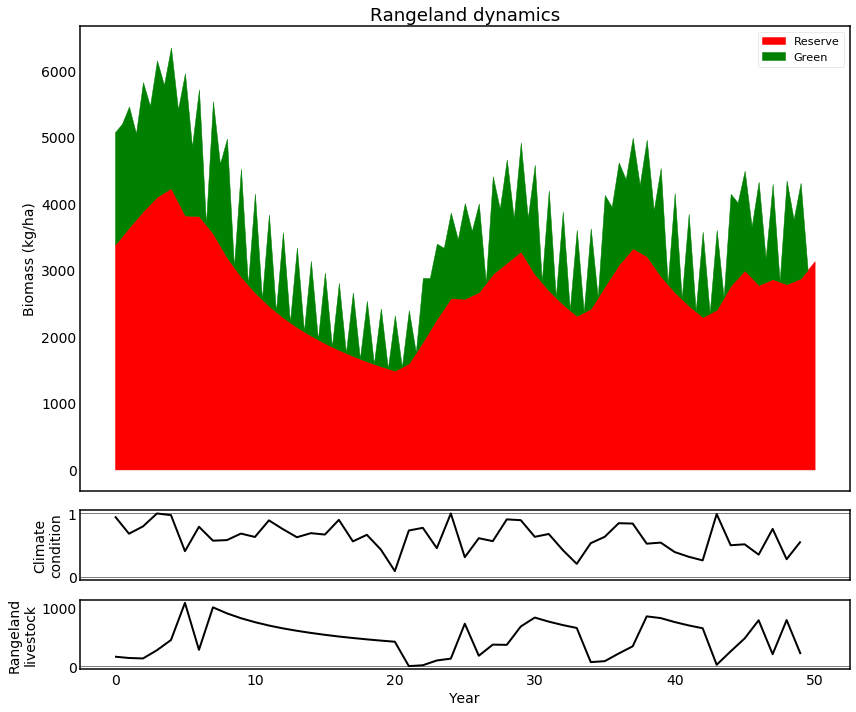

In [39]:
## plot the rangeland states
fig, axs = plt.subplots(3,1,figsize=(12,10),sharex=True, gridspec_kw={'height_ratios':[1,0.15,0.15]})
ax = axs[0]
# reserve biomass
ax.fill_between(np.arange(m.T+1), 0, m.rangeland.R, color='red', label='Reserve')
# format the green biomass
G = np.full([2*m.T], np.nan)
G[np.arange(m.T)*2] = m.rangeland.G_no_cons
G[np.arange(m.T)*2+1] = m.rangeland.G[:-1]
mids = (m.rangeland.R[:-1] + m.rangeland.R[1:]) / 2
R_all = np.full(2*m.T, np.nan)
R_all[np.arange(m.T)*2] = m.rangeland.R[:-1]
R_all[np.arange(m.T)*2+1] = mids

R_base = np.repeat(m.rangeland.R[:-1],2)
ax.fill_between(np.arange(2*m.T)/2, R_all, R_all+G, color='green', label='Green')

ax.grid(False)
ax.set_ylabel('Biomass (kg/ha)')
ax.legend()
ax.set_title('Rangeland dynamics')

# add rainfall and livestock total
axs[1].plot(m.climate.rain, color='k')
axs[1].grid(False)
axs[1].set_ylabel('Climate\ncondition')
axs[1].axhline(0, color='k', lw=0.5)
axs[1].axhline(1, color='k', lw=0.5)

axs[2].plot(m.rangeland.livestock_supported, color='k')
axs[2].grid(False)
axs[2].set_ylabel('Rangeland\nlivestock')
axs[2].set_xlabel('Year')
axs[2].axhline(0, color='k',lw=0.5)

## plots with no agent types

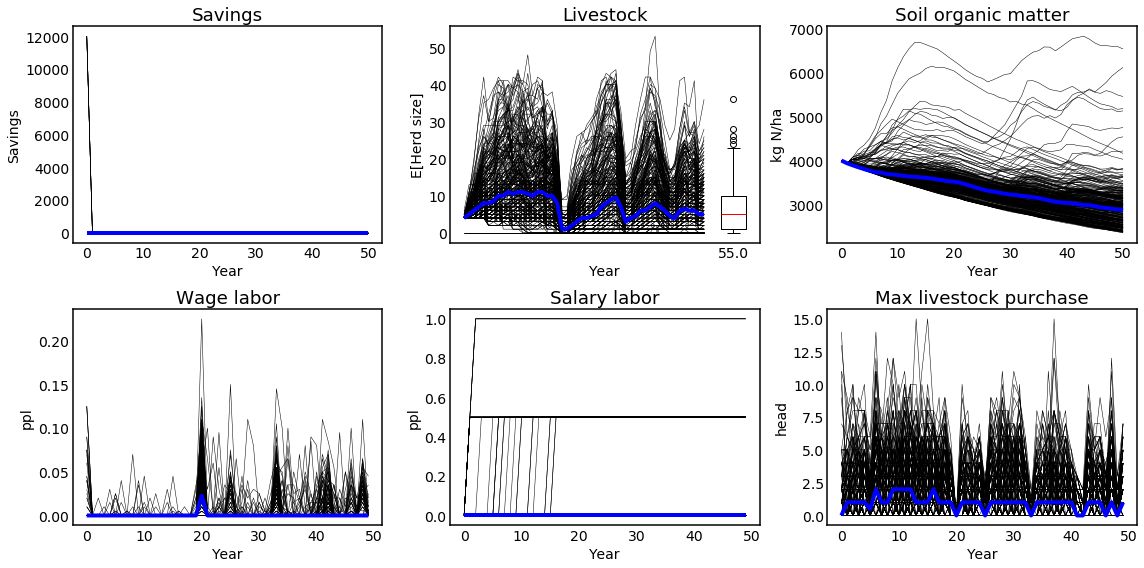

In [40]:
fig, axs = plt.subplots(2,3,figsize=(16,8))
axs = axs.flatten()

axs[0].plot(m.agents.savings, color='k', lw=0.5)
axs[0].plot(np.median(m.agents.savings, axis=1), color='b', lw=4)
axs[0].set_ylabel('Savings')
axs[0].set_title('Savings')

axs[1].plot(m.agents.livestock, color='k', lw=0.5)
axs[1].plot(np.median(m.agents.livestock, axis=1), color='b', lw=4)
axs[1].set_ylabel('E[Herd size]')
axs[1].set_title('Livestock')
axs[1].boxplot(m.agents.livestock[-1],positions=[m.T+m.T/10], widths=[int(m.T/10)])

axs[2].plot(m.land.organic, color='k', lw=0.5)
axs[2].plot(np.median(m.land.organic, axis=1), color='b', lw=4)
axs[2].set_ylabel('kg N/ha')
axs[2].set_title('Soil organic matter')

axs[3].plot(m.agents.wage_labor, color='k', lw=0.5)
axs[3].plot(np.median(m.agents.wage_labor, axis=1), color='b', lw=4)
axs[3].set_ylabel('ppl')
axs[3].set_title('Wage labor')

axs[4].plot(m.agents.salary_labor, color='k', lw=0.5)
axs[4].plot(np.median(m.agents.salary_labor, axis=1), color='b', lw=4)
axs[4].set_ylabel('ppl')
axs[4].set_title('Salary labor')

axs[5].plot(m.agents.max_ls_purchase, color='k', lw=0.5)
axs[5].plot(np.median(m.agents.max_ls_purchase, axis=1), color='b', lw=4)
axs[5].set_ylabel('head')
axs[5].set_title('Max livestock purchase')

for ax in axs:
    ax.grid(False)
    ax.set_xlabel('Year')

/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Frequency')

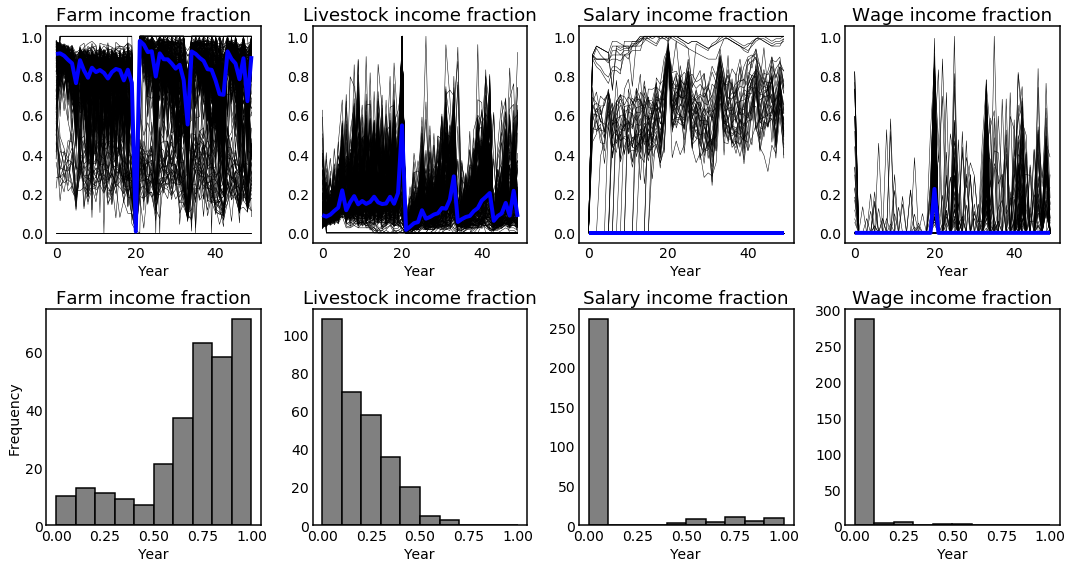

In [41]:
## agent income distribution
tplot = 40
bins = np.arange(0,1.1,0.1)
fig, axs = plt.subplots(2,4,figsize=(15,8))
objs = [m.agents.farm_income, m.agents.ls_income, m.agents.salary_income, m.agents.wage_income]
tot_income = np.sum(np.array(objs), axis=0)
titles = ['Farm income','Livestock income','Salary income', 'Wage income']
for o, obj in enumerate(objs):
    axs[0,o].plot(obj/tot_income, color='k',lw=0.5)
    axs[0,o].plot(np.nanmedian(obj/tot_income, axis=1), color='b',lw=4)
    axs[0,o].set_title(titles[o] + ' fraction')
    axs[0,o].set_xlabel('Year')
    axs[0,o].grid(False)
    
    axs[1,o].hist((obj/tot_income)[tplot], bins=bins, color='0.5', edgecolor='k', lw=1.5)
    axs[1,o].set_title(titles[o] + ' fraction')
    axs[1,o].set_xlabel('Year')
    axs[1,o].grid(False)
axs[1,0].set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

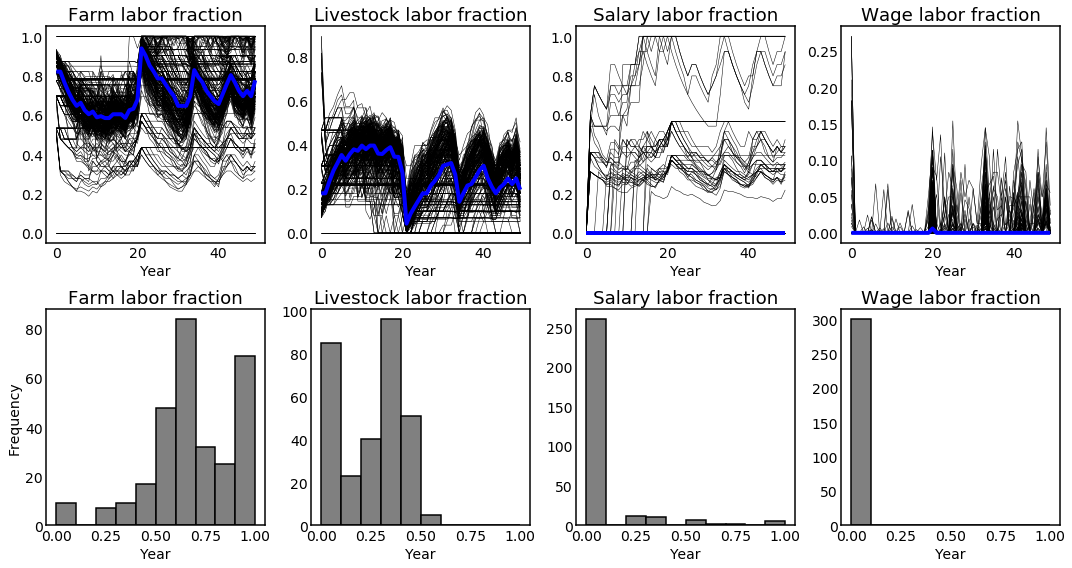

In [42]:
## agent labor distribution
tplot = 40
bins = np.arange(0,1.1,0.1)
fig, axs = plt.subplots(2,4,figsize=(15,8))
objs = [m.agents.ag_labor, m.agents.ls_labor, m.agents.salary_labor, m.agents.wage_labor]
tot_labor = np.sum(np.array(objs), axis=0)
titles = ['Farm labor','Livestock labor','Salary labor', 'Wage labor']
for o, obj in enumerate(objs):
    axs[0,o].plot(obj/tot_labor, color='k',lw=0.5)
    axs[0,o].plot(np.nanmedian(obj/tot_labor, axis=1), color='b',lw=4)
    axs[0,o].set_title(titles[o] + ' fraction')
    axs[0,o].set_xlabel('Year')
    axs[0,o].grid(False)
    
    axs[1,o].hist((obj/tot_labor)[tplot], bins=bins, color='0.5', edgecolor='k', lw=1.5)
    axs[1,o].set_title(titles[o] + ' fraction')
    axs[1,o].set_xlabel('Year')
    axs[1,o].grid(False)
axs[1,0].set_ylabel('Frequency')

In [43]:
# plt.scatter(m.agents.land_area, m.agents.livestock[-1])
# plt.scatter(m.agents.hh_size, m.agents.livestock[-1])

In [44]:
m.agents.max_ls_purchase.max()

15.0

## plots with agent types


In [ ]:
print(m.agents.ls_start[10, 0:10])
print(m.agents.ls_reprod[10, 0:10])
print(m.agents.ls_destock[10, 0:10])
print(m.agents.ls_stress[10, 0:10])

In [ ]:
## livestock
fig, ax = plt.subplots(figsize=(12,7))
# format data
ls = np.full([4*m.T, m.n_agents], np.nan)
ls[4*np.arange(m.T)] = m.agents.ls_start
ls[4*np.arange(m.T)+1] = m.agents.ls_reprod
ls[4*np.arange(m.T)+2] = m.agents.ls_destock
ls[4*np.arange(m.T)+3] = m.agents.ls_stress

t = np.arange(ls.shape[0])/4
colors = {1:'k',1.5:'r',2:'b'}
labls = []

for a in range(m.n_agents):
    land = m.agents.land_area[a]
    lgd = '_nolegend_' if land in labls else '{} ha'.format(land)
    labls.append(land)  
    ax.plot(t,ls[:,a], color=colors[land], label=lgd)
    
ax.legend()
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel('Number of livestock')
ax.set_title('Livestock by agent type')

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
colors = {1:'k',1.5:'r',2:'b'}
labls = []

for a in range(m.n_agents):
    land = m.agents.land_area[a]
#     if land == 1.5:
    lgd = '_nolegend_' if land in labls else '{} ha'.format(land)
    labls.append(land)  
    ax.plot(m.agents.wealth[:,a], color=colors[land], label=lgd)
    
ax.legend()
# ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel('Total wealth')
ax.set_title('Wealth by agent type')
ax.grid(False)

In [ ]:
import plot.ins_cc.single_run as single_run
single_run.separate(m)

In [ ]:
single_run.type_yields(m, False)

## POM

In [ ]:
np.mean(m.agents.salary_labor[-20]>0)

In [ ]:
one = True if ((p_cope>=0.3) & (p_cope<=0.45)) else False
one

In [ ]:
maxs = np.max(mod.land.organic[-n_yrs:], axis=1)
two = False if max(maxs) == mod.land.max_organic_N else True
two

In [ ]:
## 3. rangeland is not fully degrated
## A: P(regional destocking required) \in [0.1,0.5]
prob = np.mean(mod.rangeland.destocking_rqd)
threeA = True if ((prob >= 0) and (prob <= 0.5)) else False
## B: min(reserve biomass) > 0.2*R_max
threeB = True if min(mod.rangeland.R >= 0.2 * mod.rangeland.R_max) else False
## C: there are livestock on the rangeland in the last n_yrs
# threeC = True if (min(mod.rangeland.livestock_supported[-n_yrs:]) > 0) else False
three = bool(threeA * threeB)
three

In [ ]:
mod = m
## 4. livestock: 
# >80% of HHs have livestock on average
fourA = np.mean(mod.agents.livestock[-n_yrs:]>0) >= 0.8
# 90th%ile agent has less than 10 livestock on average
fourB = np.percentile(np.mean(mod.agents.livestock, axis=0), 90) < 10 # take mean over time for each agent
# median agent has less than 5 on average
fourC = np.percentile(np.mean(mod.agents.livestock, axis=0), 50) < 5
# maximum ever is less than 50
fourD = np.max(mod.agents.livestock)<50
four = bool(fourA*fourB*fourC*fourD)
print(fourA)
print(fourB)
print(fourC)
print(fourD)

In [ ]:
## 5. non-farm income
# upper and lower limits on wage and salary income
p_wage = np.mean(mod.agents.wage_labor[-n_yrs:] > 0)
p_sal = np.mean(mod.agents.salary_labor[-n_yrs:] > 0)
# print(p_sal)
fiveA = ((p_wage>0.05) & (p_wage<0.15))
fiveB = ((p_sal>0.05) & (p_sal<0.15))
# fiveA = ((p_wage>0.1) & (p_wage<0.15))
# fiveB = ((p_sal>0.05) & (p_sal<0.1))
# code.interact(local=dict(globals(), **locals()))
five = bool(fiveA*fiveB)
print(p_wage)
print(p_sal)

In [ ]:
for r in range(10):
    inputs['model']['seed'] = r
    m = mod_code.Model(inputs)
    for t in range(m.T):
        m.step()
    
    mod = m
    n_yrs = 10
#     fits.append(POM.fitting_metrics(m))

    p_cope = np.mean(mod.agents.cons_red_rqd[-n_yrs:])
    one = True if ((p_cope>=0.3) & (p_cope<=0.45)) else False
    #### NOTE: REMOVING THIS ONE BECAUSE IT CONFLICTS WITH THE WAGE AND SALARY REQUIREMENTS AND LIVESTOCK
    #### (IE HAVING 30-45% OF PEOPLE NEEDING TO COPE BUT >80% WITH LIVESTOCK AND <15% WITH WAGE IS ROUGH)

    ## 2. land degradation exists
    # not consistently someone at maximum value
    # (this is calculated over TIME, not a single AGENT that's at max) 
    maxs = np.max(mod.land.organic[-n_yrs:], axis=1)
    two = False if max(maxs) == mod.land.max_organic_N else True

    ## 3. rangeland is not fully degrated
    ## A: P(regional destocking required) \in [0.1,0.5]
    prob = np.mean(mod.rangeland.destocking_rqd)
    threeA = True if ((prob >= 0) and (prob <= 0.5)) else False
    ## B: min(reserve biomass) > 0.2*R_max
    threeB = True if min(mod.rangeland.R >= 0.2 * mod.rangeland.R_max) else False
    ## C: there are livestock on the rangeland in the last n_yrs
    # threeC = True if (min(mod.rangeland.livestock_supported[-n_yrs:]) > 0) else False
    three = bool(threeA * threeB)

    ## 4. livestock: 
    # >80% of HHs have livestock on average
    fourA = np.mean(mod.agents.livestock[-n_yrs:]>0) >= 0.8
    # 90th%ile agent has less than 10 livestock on average
    fourB = np.percentile(np.mean(mod.agents.livestock, axis=0), 90) < 10 # take mean over time for each agent
    # median agent has less than 5 on average
    fourC = np.percentile(np.mean(mod.agents.livestock, axis=0), 50) < 5
    # maximum ever is less than 50
    fourD = np.max(mod.agents.livestock)<50
    four = bool(fourA*fourB*fourC*fourD)
    # four = bool(fourA*fourB*fourD)

    ## 5. non-farm income
    # upper and lower limits on wage and salary income
    p_wage = np.mean(mod.agents.wage_labor[-n_yrs:] > 0)
    p_sal = np.mean(mod.agents.salary_labor[-n_yrs:] > 0)
    # print(p_sal)
    fiveA = ((p_wage>0.05) & (p_wage<0.15))
    fiveB = ((p_sal>0.05) & (p_sal<0.15))
    # fiveA = ((p_wage>0.1) & (p_wage<0.15))
    # fiveB = ((p_sal>0.05) & (p_sal<0.1))
    # code.interact(local=dict(globals(), **locals()))
    five = bool(fiveA*fiveB)

#     print(p_sal)
    print(p_wage)

# old stuff

In [ ]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm')
sys.path.append('../')
import model.model as mod_code
import experiments.POM as POM
import plot.single_run as plt_single
import imp
import numpy as np
import pickle
imp.reload(mod_code)
import matplotlib.pyplot as plt
import model.base_inputs as base_inputs
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [ ]:
f = '../../outputs/2019_10_15_4/POM/100000_10reps/input_params_0.pkl'
f = '../../outputs/2020_1_27_savings/POM/100000_10reps/input_params_0.pkl'
inputs = pickle.load(open(f, 'rb'))
inputs['adaptation']['burnin_period'] = 10

In [ ]:
inputs['model']['seed'] = 0
inputs['model']['T'] = 100
# inputs['agents']['wealth_init_mean'] *=1
# inputs['land']['random_effect_sd'] = 0.5
inputs['model']['n_agents'] = 60
inputs['agents']['land_area_multiplier'] = 1


# inputs['land']['wealth_N_conversion'] *= 0.9
# inputs['land']['organic_N_min_init'] = 6000
# inputs['land']['organic_N_max_init'] = 6000
# inputs['agents']['cash_req_mean'] *= 1.3
# inputs['land']['random_effect_sd'] = 0.1

# inputs['model']['adaptation_option'] = 'cover_crop'
# inputs['agents']['adap_type'] = 'always'
inputs['rangeland']['R0_frac'] = 0.3

In [ ]:
# m = mod_code.Model(inputs)
# for t in range(m.T):
#     m.step()

In [ ]:
# imp.reload(plt_single)
# plt_single.main(m, save=False)

In [ ]:
# # assess variability in yields
# print(m.land.yields.shape)
# ags = m.agents.land_area == 1.5
# o1 = np.mean(np.var(m.land.yields[:,ags], axis=0))
# o2 = np.mean(np.var(m.land.yields[:,ags], axis=1))
# print('agent variance is this fraction of annual variance')
# print(o2/o1)